# TPG Examples
This document shows how to use the PyTPG API. We make use of OpenAI Gym to run examples, and we assume you already have PyTPG installed, see the readme for installation instructions for PyTPG.

## General Setup

In [3]:
from __future__ import division
from IPython.display import clear_output
import numpy as np
import gym
import matplotlib.pyplot as plt
from IPython import display
import random
import time
# import to do training
import sys
sys.path.insert(0, '..')
from _tpg.trainer import Trainer

# import to run an agent (always needed)
# from agent import Agent
# env = gym.make('Assault-v0') # make the environment


In [4]:
# how to render in Jupyter: 
# https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
# https://www.youtube.com/watch?v=O84KgRt6AJI
def show_state(env, step=0, name='', info=''):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (name, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
# To transform pixel matrix to a single vector.
def getState(inState):
    # each row is all 1 color
    rgbRows = np.reshape(inState,(len(inState[0])*len(inState), 3)).T

    # add each with appropriate shifting
    # get RRRRRRRR GGGGGGGG BBBBBBBB
    return np.add(np.left_shift(rgbRows[0], 16), np.add(np.left_shift(rgbRows[1], 8), rgbRows[2]))


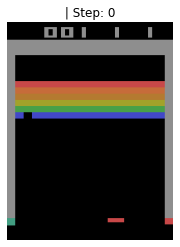

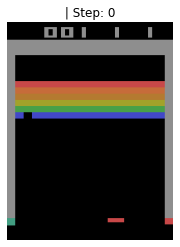

In [6]:
env = gym.make("BreakoutNoFrameskip-v4")

print("Observation Space: ", env.observation_space)
print("Action Space       ", env.action_space)


obs = env.reset()

for i in range(1000):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    show_state(env)
    time.sleep(0.01)


In [7]:
env = gym.make('CartPole-v0') # make the environment

In [10]:
env

<TimeLimit<CartPoleEnv<CartPole-v0>>>

gym.wrappers.time_limit.TimeLimit

In [15]:
print(env.action_space.n) # learn size of action space

2


## Example: Basic Generational Selection (with graphics)

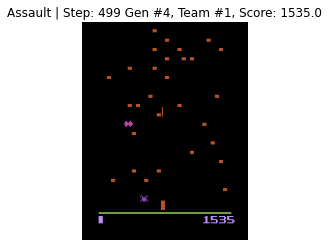

Time Taken (Hours): 0.3874525660938687
Results:
Min, Max, Avg
0.0 2027.0 637.85
55.0 3569.0 1183.6190476190477
55.0 3297.0 1282.3
55.0 2525.0 1823.65
631.0 2413.0 2033.5


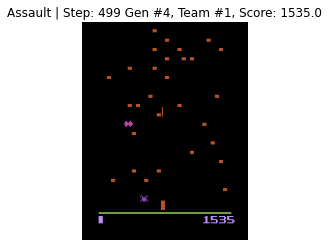

In [7]:
# from src.get_gym_envs import get_space_list, show_state, get_state


env = gym.make('Centipede-v0') # make the environment


tStart = time.time()

# first create an instance of the TpgTrainer
# this creates the whole population and everything
# teamPopSize should realistically be at-least 100
trainer = Trainer(actions=env.action_space.n, teamPopSize=20) 

curScores = [] # hold scores in a generation
summaryScores = [] # record score summaries for each gen (min, max, avg)

# 5 generations isn't much (not even close), but some improvements
# should be seen.
for gen in range(5): # generation loop
    curScores = [] # new list per gen
    
    agents = trainer.getAgents()
    
    while True: # loop to go through agents
        teamNum = len(agents)
        agent = agents.pop()
        if agent is None:
            break # no more agents, so proceed to next gen
        
        state = env.reset() # get initial state and prep environment
        score = 0
        for i in range(500): # run episodes that last 500 frames
            show_state(env, i, 'Assault', 'Gen #' + str(gen) + 
                       ', Team #' + str(teamNum) +
                       ', Score: ' + str(score)) # render env
            
            # get action from agent
            # must transform to at-least int-32 (for my getState to bitshift correctly)
            act = agent.act(getState(np.array(state, dtype=np.int32))) # -> int

            # feedback from env
            state, reward, isDone, debug = env.step(act)
            score += reward # accumulate reward in score
            if isDone:
                break # end early if losing state

        agent.reward(score) # must reward agent (if didn't already score)
            
        curScores.append(score) # store score
        
        if len(agents) == 0:
            break
            
    # at end of generation, make summary of scores
    summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    trainer.evolve()
    
#clear_output(wait=True)
print('Time Taken (Hours): ' + str((time.time() - tStart)/3600))
print('Results:\nMin, Max, Avg')
for result in summaryScores:
    print(result[0],result[1],result[2])

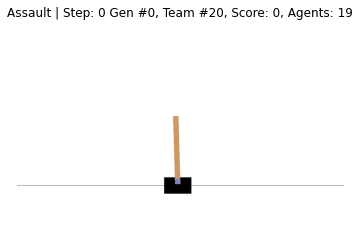

TypeError: object of type 'numpy.int32' has no len()

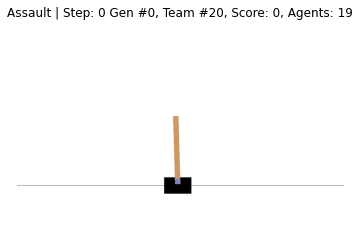

In [16]:
%matplotlib inline
import time # for tracking time
# import tqdm

tStart = time.time()

# first create an instance of the TpgTrainer
# this creates the whole population and everything
# teamPopSize should realistically be at-least 100
trainer = Trainer(actions=env.action_space.n, teamPopSize=20) 


# 5 generations isn't much (not even close), but some improvements
# should be seen.
def learning(_trainer:Trainer, _generation:int=5, _1_episode_frames:int=500)->list:
    # curScores = [] # hold scores in a generation
    summaryScores = [] # record score summaries for each gen (min, max, avg)

    for gen in range(_generation): # generation loop
        curScores = [] # new list per gen
        
        agents = trainer.getAgents()
        
        teamNum = len(agents)
        j=0
        for agent in agents:
            j+=1
            
            state = env.reset() # get initial state and prep environment
            score = 0
            for i in range(_1_episode_frames): # run episodes that last 500 frames
                show_state(env, i, 'Assault', 'Gen #' + str(gen) + 
                       ', Team #' + str(teamNum) +
                       ', Score: ' + str(score)+
                       ', Agents: '+str(teamNum-j)) # render env
                # get action from agent
                # must transform to at-least int-32 (for my getState to bitshift correctly)
                act = agent.act(getState(np.array(state, dtype=np.int32)))
                

                # feedback from env
                state, reward, isDone, debug = env.step(act)
                score += reward # accumulate reward in score

                if isDone: break # end early if losing state

            agent.reward(score) # must reward agent (if didn't already score)
                
            curScores.append(score) # store score
            
        # at end of generation, make summary of scores
        summaryScores.append((min(curScores), max(curScores), sum(curScores)/len(curScores))) # min, max, avg
        trainer.evolve()

    return summaryScores
result = learning(trainer)
#clear_output(wait=True)
# print('Time Taken (Hours): ' + str((time.time() - tStart)/3600))
# print('Results:\nMin, Max, Avg')
# for result in summaryScores:
#     print(result[0],result[1],result[2])
# for i in result:
#     print(i[0],i[1],i[2])

## Example: Generational Selection with Multiprocessing (no graphics)

This example is just to show a different way to run the API, a far superior way. It uses a different method to get the agents, doesn't use graphics (but can), and uses multiprocessing.

In [18]:
"""
Run each agent in this method for parallization.
Args:
    args: (TpgAgent, envName, scoreList, numEpisodes, numFrames)
"""

def runAgent(args:list[Agent, str, list, int, int]):
    agent = args[0]
    envName = args[1]
    scoreList = args[2]
    numEpisodes = args[3] # number of times to repeat game
    numFrames = args[4] 
    
    # skip if task already done by agent
    if agent.taskDone(envName):
        print('Agent #' + str(agent.agentNum) + ' can skip.')
        scoreList.append((agent.team.id, agent.team.outcomes))
        return
    
    env = gym.make(envName)
    valActs = range(env.action_space.n) # valid actions, some envs are less
    
    scoreTotal = 0 # score accumulates over all episodes
    for ep in range(numEpisodes): # episode loop
        state = env.reset()
        scoreEp = 0
        numRandFrames = 0
        if numEpisodes > 1:
            numRandFrames = random.randint(0,30)
        for i in range(numFrames): # frame loop
            if i < numRandFrames:
                env.step(env.action_space.sample())
                continue

            act = agent.act(getState(np.array(state, dtype=np.int32)))

            # feedback from env
            state, reward, isDone, debug = env.step(act)
            scoreEp += reward # accumulate reward in score
            if isDone:
                break # end early if losing state
                
        print('Agent #' + str(agent.agentNum) + 
              ' | Ep #' + str(ep) + ' | Score: ' + str(scoreEp))
        scoreTotal += scoreEp
       
    scoreTotal /= numEpisodes
    env.close()
    agent.reward(scoreTotal, envName)
    scoreList.append((agent.team.id, agent.team.outcomes))

In [22]:
import multiprocessing as mp
import time
from tqdm import tqdm


envName = 'Boxing-v0'
# get num actions
env = gym.make(envName)
acts = env.action_space.n
del env

trainer = Trainer(actions=acts, teamPopSize=360)

processes = 2
man = mp.Manager()
pool = mp.Pool(processes=processes, maxtasksperchild=1)
    
allScores = [] # track all scores each generation

tStart = time.time()
for gen in tqdm(range(100)): # do 100 generations of training
    scoreList = man.list()
    
    # get agents, noRef to not hold reference to trainer in each one
    # don't need reference to trainer in multiprocessing
    agents = trainer.getAgents() # swap out agents only at start of generation

    process_seed = [[agent, envName, scoreList, 1, 18000] for agent in agents]

    # run the agents
    pool.map(runAgent, process_seed)
    
    # apply scores, must do this when multiprocessing
    # because agents can't refer to trainer
    teams = trainer.applyScores(scoreList)
    # important to remember to set tasks right, unless not using task names
    # task name set in runAgent()
    trainer.evolve(tasks=[envName]) # go into next gen
    
    # an easier way to track stats than the above example
    scoreStats = trainer.fitnessStats
    allScores.append((scoreStats['min'], scoreStats['max'], scoreStats['average']))
    
    clear_output()
    print('Time Taken (Hours): ' + str((time.time() - tStart)/3600))
    print('Gen: ' + str(gen))
    print('Results so far: ' + str(allScores))
    
clear_output()
print('Time Taken (Hours): ' + str((time.time() - tStart)/3600))
print('Results:\nMin, Max, Avg')
for score in allScores:
    print(score[0],score[1],score[2])

  0%|          | 0/100 [00:00<?, ?it/s]Process SpawnPoolWorker-18:
Traceback (most recent call last):
  File "/Users/matsuzawakazuki/miniforge3/envs/tpgenv/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/matsuzawakazuki/miniforge3/envs/tpgenv/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/matsuzawakazuki/miniforge3/envs/tpgenv/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/matsuzawakazuki/miniforge3/envs/tpgenv/lib/python3.10/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'runAgent' on <module '__main__' (built-in)>
Process SpawnPoolWorker-19:
Traceback (most recent call last):
  File "/Users/matsuzawakazuki/miniforge3/envs/tpgenv/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/matsuzawakazuki/mini

KeyboardInterrupt: 

In [21]:
# coding: utf-8
from tqdm import tqdm
import time

for i in tqdm(range(100)):
    time.sleep(1)
#100%|██████████| 100/100 [01:40<00:00,  1.00s/it]

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


In [23]:
from multiprocessing import Process
import os

def info(title):
    print(title)
    print('module name:', __name__)
    print('parent process:', os.getppid())
    print('process id:', os.getpid())

def f(name):
    info('function f')
    print('hello', name)

info('main line')
p = Process(target=f, args=('bob',))
p.start()
p.join()

main line
module name: __main__
parent process: 1383
process id: 13779


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/matsuzawakazuki/miniforge3/envs/tpgenv/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/matsuzawakazuki/miniforge3/envs/tpgenv/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'f' on <module '__main__' (built-in)>
